
# Trabalho 1: Diferenciação Automática com Grafos Computacionais

## Informações Gerais

- Data de Entrega: 29/06/2025
- Pontuação: 10 pontos (+4 pontos extras)
- O trabalho deve ser feito individualmente.
- A entrega do trabalho deve ser realizada via sistema testr.



## Especificação

⚠️ *Esta explicação assume que você leu e entendeu os slides sobre grafos computacionais.*

O trabalho consiste em implementar um sistema de diferenciação automática usando grafos computacionais e utilizar este sistema para resolver um conjunto de problemas.

Para isto, devem ser definidos um tipo Tensor para representar dados (similares aos arrays do numpy) e operações (e.g., soma, subtração, etc.) que geram tensores como saída. 

Sempre que uma operação é realizada, é armazenado no tensor de saída referências para os seus pais, isto é, os valores usados como entrada para a operação. 


### Imports

In [96]:
from typing import Optional, Union, Any
from collections.abc import Iterable
from abc import ABC, abstractmethod
import numbers

import numpy as np                          
import matplotlib.pyplot as plt                                                     
import seaborn as sns

sns.set_style('whitegrid')

### Classe NameManager

A classe NameManager provê uma forma conveniente de dar nomes intuitivos para tensores que resultam de operações. A idéia é tornar mais fácil para o usuário das demais classes qual operação gerou qual tensor. Ela provê os seguintes métodos públicos: 

- reset(): reinicia o sistema de gestão de nomes.
- new(<basename>: str): retorna um nome único a partir do nome de base passado como argumento. 
  
Como indicado no exemplo abaixo da classe, a idéia geral é que uma sequência de operações é feita, os nomes dos tensores sejam os nomes das operações seguidos de um número. Se forem feitas 3 operações de soma e uma de multiplicação, seus tensores de saída terão os nomes "add:0", "add:1", "add:2" e "prod:0".

In [97]:

class NameManager:                                                                                                                  
    _counts = {}

    @staticmethod
    def reset():    
        NameManager._counts = {}

    @staticmethod
    def _count(name):
        if name not in NameManager._counts:
            NameManager._counts[name] = 0
        count = NameManager._counts[name]
        return count

    @staticmethod
    def _inc_count(name):
        assert name in NameManager._counts, f'Name {name} is not registered.'
        NameManager._counts[name] += 1

    @staticmethod
    def new(name: str):
        count = NameManager._count(name)
        tensor_name = f"{name}:{count}"
        NameManager._inc_count(name)
        return tensor_name

# exemplo de uso
print(NameManager.new('add'))
print(NameManager.new('in'))
print(NameManager.new('add'))
print(NameManager.new('add'))
print(NameManager.new('in'))
print(NameManager.new('prod'))

NameManager.reset()

add:0
in:0
add:1
add:2
in:1
prod:0


### Classe Tensor

Deve ser criada uma classe `Tensor` representando um array multidimensional.

In [98]:

class Tensor:
    """Classe representando um array multidimensional.

    Atributos:

    - _arr  (privado): dados internos do tensor como
        um array do numpy com 2 dimensões (ver Regras)

    - _parents (privado): lista de tensores que foram
        usados como argumento para a operação que gerou o
        tensor. Será vazia se o tensor foi inicializado com
        valores diretamente. Por exemplo, se o tensor foi
        resultado da operação a + b entre os tensores a e b,
        _parents = [a, b].

    - requires_grad (público): indica se devem ser
        calculados gradientes para o tensor ou não.

    - grad (público): Tensor representando o gradiente.

    """

    def __init__(self,
                 # Dados do tensor. Além dos tipos listados,
                 # arr também pode ser do tipo Tensor.
                 arr: Union[np.ndarray, list, numbers.Number, Any],
                 # Entradas da operacao que gerou o tensor.
                 # Deve ser uma lista de itens do tipo Tensor.
                 parents: list[Any] = [],
                 # se o tensor requer o calculo de gradientes ou nao
                 requires_grad: bool = True,
                 # nome do tensor
                 name: str = '',
                 # referência para um objeto do tipo Operation (ou
                 # subclasse) indicando qual operação gerou este
                 # tensor. Este objeto também possui um método
                 # para calcular a derivada da operação.
                 operation=None):
        """Construtor

        O construtor deve permitir a criacao de tensores das seguintes formas:

            # a partir de escalares
            x = Tensor(3)

            # a partir de listas
            x = Tensor([1,2,3])

            # a partir de arrays
            x = Tensor(np.array([1,2,3]))

            # a partir de outros tensores (construtor de copia)
            x = Tensor(Tensor(np.array([1,2,3])))

        Para isto, as seguintes regras devem ser obedecidas:

        - Se o argumento arr não for um array do numpy,
            ele deve ser convertido em um. Defina o dtype do
            array como float de forma a permitir que NÃO seja
            necessário passar constantes float como Tensor(3.0),
            mas possamos criar um tensor apenas com Tensor(3).

        - O atributo _arr deve ser uma matriz, isto é,
            ter 2 dimensões (ver Regras).

        - Se o argumento arr for um Tensor, ele deve ser
            copiado (cuidado com cópias por referência).

        - Se arr for um array do numpy com 1 dimensão,
            ele deve ser convertido em uma matriz coluna.

        - Se arr for um array do numpy com dimensão maior
            que 2, deve ser lançada uma exceção.

        - Tensores que não foram produzidos como resultado
            de uma operação não têm pais nem operação.
            Os nomes destes tensores devem seguir o formato in:3.
        """

        
        self._arr = self.__set_arr(arr)
        assert len(self._arr.shape) <= 2, f"[SizeError] Dimensão deve ser < 2, dimensão do array é {len(self._arr.shape)}"
        
        if isinstance(arr, Tensor):
            self._copy_from_tensor(arr, requires_grad)
        else:
            self._arr = self.__set_arr(arr)
            assert len(self._arr.shape) <= 2, f"[SizeError] Dimensão deve ser < 2, dimensão do array é {len(self._arr.shape)}"
            self._parents = parents
            self.requires_grad = requires_grad
            self.operation = operation
            
            if len(self._parents) == 0 and self.operation is None:
                self._name = NameManager.new('in')
            else:
                self._name = name
            
            self.grad = self.zero_grad() if requires_grad else None
            
    def _copy_from_tensor(self, tensor, requires_grad=None):
        self._arr = self.__set_arr(tensor.numpy().copy())
        self._name = tensor._name
        self._parents = tensor._parents.copy() if tensor._parents else []
        
        # Allow overriding requires_grad during copy
        if requires_grad is None:
            requires_grad = tensor.requires_grad
        
        self.requires_grad = requires_grad
        self.grad = self.zero_grad() if requires_grad else None
        self.operation = tensor.operation
    
    def __set_arr(self, arr):
        self._types = {int: lambda arr: np.array([[arr]], dtype=float),
                       float: lambda arr: np.array([[arr]], dtype=float),
                       np.float64: lambda arr: np.array([[arr]], dtype=float),
                       np.float32: lambda arr: np.array([[arr]], dtype=float),
                       np.int64: lambda arr: np.array([[arr]], dtype=float),
                       np.int32: lambda arr: np.array([[arr]], dtype=float),
                       list: lambda arr: np.c_[np.array(arr, dtype=float)],
                       np.ndarray: lambda arr:np.c_[arr.astype(float)], 
                       Tensor: lambda arr: self.__set_arr(arr.numpy().copy())}
        
        arr_type = type(arr)
        assert arr_type in self._types, f"[TypeError] Tipo de proibido de array, precisa ser int(), list(), np.ndarray(), Tensor(), o array é {arr_type}."
        
        return self._types[arr_type](arr)
        
    def zero_grad(self):
        """Reinicia o gradiente com zero"""
        self.grad = Tensor(np.zeros(self._arr.shape, dtype=float), requires_grad=False, name=f"{self._name}_grad", operation=None)
        return self.grad
    
    def numpy(self):
        """Retorna o array interno"""
        return self._arr

    def __repr__(self):
        """Permite visualizar os dados do tensor como string"""
        return f"Tensor({self._arr}, name={self._name}, shape={self._arr.shape})"

    def backward(self, my_grad=None):
        """Método usado tanto iniciar o processo de
        diferenciação automática, quanto por um filho
        para enviar o gradiente do pai. No primeiro
        caso, o argumento my_grad não será passado.
        """
        if my_grad is None:
            self.grad = Tensor([1]*len(self._arr), requires_grad=False, name=f"{self._name}_out", operation=None)
        # print("Doing Backward for", self._name, self._arr)
        # print("Grad:", self.grad)
        if not self.requires_grad:
            return
        
        if self.operation is not None:
            parent_grads = self.operation.grad(self.grad, self._parents, )
            # print(parent_grads)
            # print()
            for i in range(len(self._parents)):
                # print(parent_grads[i].numpy(), self._parents[i].grad.numpy())
                self._parents[i].grad = Tensor(self._parents[i].grad.numpy() + parent_grads[i].numpy())
                # print("Resulting Gradient:", self._parents[i]._name, self._parents[i].grad)
                self._parents[i].backward(my_grad=True)
            
            


In [99]:
entries = {"int":1, "list":[1,2,3,4], "np.darray": np.array([[1,2,3,4],[5,6,7,8]]), "Tensor":Tensor(arr=[[1,2,3,4],[5,6,7,8]], name='Tensor')}

for entry in entries:
    print(Tensor(arr=entries[entry], name=entry), end='\n\n')

Tensor([[1.]], name=in:2, shape=(1, 1))

Tensor([[1.]
 [2.]
 [3.]
 [4.]], name=in:4, shape=(4, 1))

Tensor([[1. 2. 3. 4.]
 [5. 6. 7. 8.]], name=in:6, shape=(2, 4))

Tensor([[1. 2. 3. 4.]
 [5. 6. 7. 8.]], name=in:0, shape=(2, 4))



In [100]:
t = Tensor([1,2,3], name='grad')
print(t)
print(t.grad)

Tensor([[1.]
 [2.]
 [3.]], name=in:9, shape=(3, 1))
Tensor([[0.]
 [0.]
 [0.]], name=in:10, shape=(3, 1))


### Interface de  Operações

A classe abaixo define a interface que as operações devem implementar. Ela não precisa ser modificada, mas pode, caso queira.

In [101]:

class Op(ABC):
    @abstractmethod
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando as entradas e
            retorna o tensor resultado. O método deve
            garantir que o atributo parents do tensor
            de saída seja uma lista de tensores."""

    @abstractmethod
    
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna os gradientes dos pais em como tensores.

        Arguments:

        - back_grad: Derivada parcial em relação à saída
            da operação backpropagada pelo filho.

        - args: variaveis de entrada da operacao (pais)
            como tensores.

        - O nome dos tensores de gradiente devem ter o
            nome da operacao seguido de '_grad'.
        """
    
    def _tensor(self, args):
        tensors = []
        for i in range(len(args)):
            tensors.append(args[i] if isinstance(args[i], Tensor) else Tensor(args[i], name=NameManager.new('in')))
        
        return tensors


### Implementação das Operações

Operações devem herdar de `Op` e implementar os métodos `__call__` e `grad`.

Pelo menos as seguintes operações devem ser implementadas:



In [102]:

class Add(Op):
    """Add(a, b): a + b"""
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        
        def _Add(a, b):
            return a + b
        
        args = self._tensor(args)
        
        results = _Add(args[0].numpy(), args[1].numpy())
        
        return Tensor(results, parents=args, name=NameManager.new('add'), operation=self)
    
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        
        derivative = 1
        
        return [Tensor(derivative*back_grad.numpy(), name=NameManager.new(f'{args[0][i]._name}_grad')) for i in range(len(args[0]))]
        
# Instancia a classe. O objeto passa a poder ser usado como uma funcao
add = Add()

In [103]:

class Sub(Op):
    """Sub(a, b): a - b"""
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        
        def _Sub(a, b):
            return a - b
        
        args = self._tensor(args)
        
        results = _Sub(args[0].numpy(), args[1].numpy())
        
        return Tensor(results, parents=args, name=NameManager.new('sub'), operation=self)
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        
        derivative = lambda i: (1 if i%2 == 0 else -1)
        
        return [Tensor(derivative(i)*back_grad.numpy(), name=NameManager.new(f'{args[0][i]._name}_grad')) for i in range(len(args[0]))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
sub = Sub()

In [104]:

class Prod(Op):
    """Prod(a, b): produto ponto a ponto de a e b ou produto escalar-tensor"""
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        
        def _Prod(a, b):
            return a * b
        
        args = self._tensor(args)
        
        results = _Prod(args[0].numpy(), args[1].numpy())
        
        return Tensor(results, parents=args, name=NameManager.new('prod'), operation=self)
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        
        parents = args[0]
        derivative = lambda i: parents[i + (1 if i%2 == 0 else -1)].numpy()
        
        return [Tensor(derivative(i)*back_grad.numpy(), name=NameManager.new(f'{parents[0]._name}_grad')) for i in range(len(parents))]
# Instancia a classe. O objeto passa a poder ser usado como uma funcao
prod = Prod()

In [105]:

class Sin(Op):
    """seno element-wise"""
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
       
        def _Sin(a):
            return np.sin(a)
        
        args = self._tensor(args)
        
        results = _Sin(args[0].numpy())
        
        return Tensor(results, parents=args, name=NameManager.new('sin'), operation=self)
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        parents = args[0]
        derivative = np.cos(parents[0].numpy())
        
        return [Tensor(derivative*back_grad.numpy(), name=NameManager.new(f'{parents[0]._name}_grad')) for i in range(len(parents))]
# Instancia a classe. O objeto passa a poder ser usado como uma funcao
sin = Sin()

In [106]:

class Cos(Op):
    """cosseno element-wise"""
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        
        def _Cos(a):
            return np.cos(a)
        
        args = self._tensor(args)
        
        results = _Cos(args[0].numpy())
        
        return Tensor(results, parents=args, name=NameManager.new('cos'), operation=self)
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        parents = args[0]
        derivative = -np.sin(parents[0].numpy())
        return [Tensor(derivative*back_grad.numpy(), name=NameManager.new(f'{parents[0]._name}_grad')) for i in range(len(parents))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
cos = Cos()

In [107]:

class Sum(Op):
    """Retorna a soma dos elementos do tensor"""
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        
        def _Sum(a):
            return np.sum(a)
        
        args = self._tensor(args)
        
        results = _Sum(args[0].numpy())
        
        return Tensor(results, parents=args, name=NameManager.new('my_sum'), operation=self)
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        derivative = 1
        return [Tensor(derivative*back_grad.numpy(), name=NameManager.new(f'{args[0][i]._name}_grad')) for i in range(len(args[0]))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
# ⚠️ vamos chamar de my_sum porque python ja possui uma funcao sum
my_sum = Sum()

In [108]:

class Mean(Op):
    """Retorna a média dos elementos do tensor"""
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        
        def _Mean(a):
            return np.mean(a)
        
        args = self._tensor(args)
        
        results = _Mean(args[0].numpy())
        
        return Tensor(results, parents=args, name=NameManager.new('mean'), operation=self)
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        parents = args[0]
        derivative = 1/len(parents[0].numpy())
        return [Tensor(derivative*back_grad.numpy(), name=NameManager.new(f'{args[0][i]._name}_grad')) for i in range(len(args[0]))]
# Instancia a classe. O objeto passa a poder ser usado como uma funcao
mean = Mean()

In [109]:

class Square(Op):
    """Eleva cada elemento ao quadrado"""
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        
        def _Square(a):
            return np.square(a)
        
        args = self._tensor(args)
        
        results = _Square(args[0].numpy())
        
        return Tensor(results, parents=args, name=NameManager.new('square'), operation=self)
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        parents = args[0]
        derivative = 2 * parents[0].numpy()
        return [Tensor(derivative*back_grad.numpy(), name=NameManager.new(f'{args[0][i]._name}_grad')) for i in range(len(args[0]))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
square = Square()

In [110]:

class MatMul(Op):
    """MatMul(A, B): multiplicação de matrizes

    C = A @ B
    de/dA = de/dc @ B^T
    de/dB = A^T @ de/dc

    """
    
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        
        def _MatMul(a, b):
            return a @ b
        
        args = self._tensor(args)
        
        results = _MatMul(args[0].numpy(), args[1].numpy())
    
        return Tensor(results, parents=args, name=NameManager.new('matmul'), operation=self)
    
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        parents = args[0]
        derivative = lambda i, back_grad: back_grad.numpy() @ parents[1].numpy().T if i == 0 else parents[0].numpy().T @ back_grad.numpy()
        return [Tensor(derivative(i, back_grad), name=NameManager.new(f'{args[0][i]._name}_grad')) for i in range(len(args[0]))]
    
# Instancia a classe. O objeto passa a poder ser usado como uma funcao
matmul = MatMul()

In [111]:

class Exp(Op):
    """Exponenciação element-wise"""
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        
        def _Exp(a):
            return np.exp(a)
        
        args = self._tensor(args)
        
        results = _Exp(args[0].numpy())
    
        return Tensor(results, parents=args, name=NameManager.new('exp'), operation=self)
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        parents = args[0]
        derivative = np.exp(parents[0].numpy())
        return [Tensor(derivative*back_grad.numpy(), name=NameManager.new(f'{args[0][i]._name}_grad')) for i in range(len(args[0]))]
# Instancia a classe. O objeto passa a poder ser usado como uma funcao
exp = Exp()

In [112]:

class ReLU(Op):
    """ReLU element-wise"""
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        
        def _ReLU(a):
            return np.maximum(0, a)
        
        args = self._tensor(args)
        results = _ReLU(args[0].numpy())
        
        return Tensor(results, parents=args, name=NameManager.new('relu'), operation=self)
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        parents = args[0]
        derivative = np.where(parents[0].numpy() > 0, 1, 0)
        return [Tensor(derivative*back_grad.numpy(), name=NameManager.new(f'{args[0][i]._name}_grad')) for i in range(len(args[0]))]
# Instancia a classe. O objeto passa a poder ser usado como uma funcao
relu = ReLU()

In [113]:

class Sigmoid(Op):
    """Sigmoid element-wise"""
    results = None
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""

        def _Sigmoid(a):
            return 1 / (1 + np.exp(-a))
        
        args = self._tensor(args)
        results = _Sigmoid(args[0].numpy())
        
        self.results = results.copy()
        
        return Tensor(results, parents=args, name=NameManager.new('sigmoid'), operation=self)
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        parents = args[0]
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        derivative = sigmoid(parents[0].numpy()) * (1 - sigmoid(parents[0].numpy()))
        return [Tensor(derivative*back_grad.numpy(), name=NameManager.new(f'{args[0][i]._name}_grad')) for i in range(len(args[0]))]
    
# Instancia a classe. O objeto passa a poder ser usado como uma funcao
sigmoid = Sigmoid()

In [114]:

class Tanh(Op):
    """Tanh element-wise"""
    results = None
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        def _Tanh(a):
            return np.tanh(a)
        
        args = self._tensor(args)
        results =  _Tanh(args[0].numpy())
        
        self.results = results.copy()
        return Tensor(results, parents=args, name=NameManager.new('tanh'), operation=self)
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        parents = args[0]
        derivative =  1 - np.tanh(parents[0].numpy())**2
        return [Tensor(derivative*back_grad.numpy(), name=NameManager.new(f'{args[0][i]._name}_grad')) for i in range(len(args[0]))]
# Instancia a classe. O objeto passa a poder ser usado como uma funcao
tanh = Tanh()

In [115]:

class Softmax(Op):
    """Softmax de um array de valores. Lembre-se que cada elemento do array influencia o resultado da função para todos os demais elementos."""
    results = None
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        def _Softmax(a):
            r = np.exp(a - np.max(a))
            return r / r.sum(axis=0)
        
        args = self._tensor(args)
        results =  _Softmax(args[0].numpy())
        
        self.results = results.copy()
        return Tensor(results, parents=args, name=NameManager.new('softmax'), operation=self)
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        parents = args[0]
        derivative = np.zeros((len(parents[0].numpy()), len(parents[0].numpy())))
        print("RESULTS:", self.results)
        for i in range(len(parents[0].numpy())):
            for j in range(len(parents[0].numpy())):
                if i == j: # Diagonal
                    derivative[i][j] = self.results[i, 0] * (1 - self.results[j, 0])
                else:
                    derivative[i][j] = -self.results[i, 0] * self.results[j, 0]
                    
        return [Tensor(derivative @ back_grad.numpy(), name=NameManager.new(f'{args[0][i]._name}_grad')) for i in range(len(args[0]))]
# Instancia a classe. O objeto passa a poder ser usado como uma funcao
softmax = Softmax()


### ‼️ Regras e Pontos de Atenção‼️

- Vamos fazer a hipótese simplificadora que Tensores devem ser sempre matrizes. Por exemplo, o escalar 2 deve ser armazado em `_arr` como a matriz `[[2]]`. De forma similar, a lista `[1, 2, 3]` deve ser armazenada em `_arr` como em uma matriz coluna.

- Devem ser realizados `asserts` nas operações para garantir que os shapes dos operandos fazem sentido. Esta verificação também deve ser feita depois das operações que manipulam gradientes de tensores.

- Devem ser respeitados os nomes dos atributos, métodos e classes para viabilizar os testes automáticos.

- Gradientes devem ser calculados usando uma passada pelo grafo computacional.

- Os gradientes devem ser somados e não substituídos nas chamadas de  backward. Isto vai permitir que os gradientes sejam acumulados entre amostras do dataset e que os resultados sejam corretos mesmo em caso de ramificações e junções no grafo computacional.

- Lembre-se de zerar os gradientes após cada passo de gradient descent (atualização dos parâmetros).


## Testes Básicos

Estes testes avaliam se a derivada da função está sendo calculada corretamente, mas em muitos casos **não** avaliam se os gradientes backpropagados estão sendo incorporados corretamente. Esta avaliação será feita nos problemas da próxima seção.

Operador de Soma

In [116]:
# add

a = Tensor([1.0, 2.0, 3.0])
b = Tensor([4.0, 5.0, 6.0])
c = add(a, b)
d = add(c, 3.0)
d.backward()
# print(a.grad)
# print(b.grad)

# print("A", a)
# print("A parents", a._parents)
# print("A grad", a.grad)
# print()
# print("B", b)
# print("B parents", b._parents)
# print("B grad", b.grad)
# print()
# print("C", c)
# print("C parents", c._parents)
# print("C grad", c.grad)
# print()
# print("D", d)
# print("D parents", d._parents)
# print("D grad", d.grad)
# print()

# esperado: matrizes coluna contendo 1
print(a.grad)
print(b.grad)


Tensor([[1.]
 [1.]
 [1.]], name=in:31, shape=(3, 1))
Tensor([[1.]
 [1.]
 [1.]], name=in:33, shape=(3, 1))


Operador de Subtração

In [117]:
# sub

a = Tensor([1.0, 2.0, 3.0])
b = Tensor([4.0, 5.0, 6.0])
c = sub(a, b)
d = sub(c, 3.0)
d.backward()

# esperado: matrizes coluna contendo 1 e -1
print(a.grad)
print(b.grad)


Tensor([[1.]
 [1.]
 [1.]], name=in:57, shape=(3, 1))
Tensor([[-1.]
 [-1.]
 [-1.]], name=in:59, shape=(3, 1))


Operador de Produto

In [118]:
# prod

a = Tensor([1.0, 2.0, 3.0])
b = Tensor([4.0, 5.0, 6.0])
c = prod(a, b)
d = prod(c, 3.0)
d.backward()

# esperado: [12, 15, 18]^T
print(a.grad)
# esperado: [3, 6, 9]^T
print(b.grad)


Tensor([[12.]
 [15.]
 [18.]], name=in:83, shape=(3, 1))
Tensor([[3.]
 [6.]
 [9.]], name=in:85, shape=(3, 1))


Operadores trigonométricos

In [119]:
# sin e cos

a = Tensor([np.pi, 0, np.pi/2])
b = sin(a)
c = cos(a)
d = my_sum(add(b, c))
d.backward()

# esperado: [-1, 1, -1]^T
print(a.grad)

Tensor([[-1.]
 [ 1.]
 [-1.]], name=in:114, shape=(3, 1))


In [120]:
# Sum

a = Tensor([3.0, 1.0, 0.0, 2.0])
b = add(prod(a, 3.0), a)
c = my_sum(b)
c.backward()

# esperado: [4, 4, 4, 4]^T
print(a.grad)


Tensor([[4.]
 [4.]
 [4.]
 [4.]], name=in:143, shape=(4, 1))


In [121]:
# Mean

a = Tensor([3.0, 1.0, 0.0, 2.0])
b = mean(a)
b.backward()

# esperado: [0.25, 0.25, 0.25, 0.25]^T
print(a.grad)


Tensor([[0.25]
 [0.25]
 [0.25]
 [0.25]], name=in:151, shape=(4, 1))


In [122]:
# Square

a = Tensor([3.0, 1.0, 0.0, 2.0])
b = square(a)

# esperado: [9, 1, 0, 4]^T
print(b)

b.backward()

# esperado: [6, 2, 0, 4]
print(a.grad)

Tensor([[9.]
 [1.]
 [0.]
 [4.]], name=square:0, shape=(4, 1))
Tensor([[6.]
 [2.]
 [0.]
 [4.]], name=in:159, shape=(4, 1))


In [123]:
# matmul

W = Tensor([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
])

v = Tensor([1.0, 2.0, 3.0])

z = matmul(W, v)

# esperado: [14, 32, 50]^T
print(z)

z.backward()

# esperado:
# [1, 2, 3]
# [1, 2, 3]
# [1, 2, 3]
print(W.grad)

# esperado: [12, 15, 18]^T
print(v.grad)


Tensor([[14.]
 [32.]
 [50.]], name=matmul:0, shape=(3, 1))
Tensor([[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]], name=in:171, shape=(3, 3))
Tensor([[12.]
 [15.]
 [18.]], name=in:173, shape=(3, 1))


In [124]:
# Exp

v = Tensor([1.0, 2.0, 3.0])
w = exp(v)

# esperado: [2.718..., 7.389..., 20.085...]^T
print(w)

w.backward()

# esperado: [2.718..., 7.389..., 20.085...]^T
print(v.grad)

Tensor([[ 2.71828183]
 [ 7.3890561 ]
 [20.08553692]], name=exp:0, shape=(3, 1))
Tensor([[ 2.71828183]
 [ 7.3890561 ]
 [20.08553692]], name=in:181, shape=(3, 1))


In [125]:
# Relu

v = Tensor([-1.0, 0.0, 1.0, 3.0])
w = relu(v)

# esperado: [0, 0, 1, 3]^T
print(w)

w.backward()

# esperado: [0, 0, 1, 1]^T
print(v.grad)

Tensor([[0.]
 [0.]
 [1.]
 [3.]], name=relu:0, shape=(4, 1))
Tensor([[0.]
 [0.]
 [1.]
 [1.]], name=in:189, shape=(4, 1))


In [126]:
# Sigmoid

v = Tensor([-1.0, 0.0, 1.0, 3.0])
w = sigmoid(v)

# esperado: [0.268.., 0.5, 0.731.., 0.952..]^T
print(w)

w.backward()

# esperado: [0.196..., 0.25, 0.196..., 0.045...]^T
print(v.grad)

Tensor([[0.26894142]
 [0.5       ]
 [0.73105858]
 [0.95257413]], name=sigmoid:0, shape=(4, 1))
Tensor([[0.19661193]
 [0.25      ]
 [0.19661193]
 [0.04517666]], name=in:197, shape=(4, 1))


In [127]:
# Tanh

v = Tensor([-1.0, 0.0, 1.0, 3.0])
w = tanh(v)

# esperado: [[-0.76159416, 0., 0.76159416, 0.99505475]^T
print(w)

w.backward()

# esperado: [0.41997434, 1., 0.41997434, 0.00986604]^T
print(v.grad)

Tensor([[-0.76159416]
 [ 0.        ]
 [ 0.76159416]
 [ 0.99505475]], name=tanh:0, shape=(4, 1))
Tensor([[0.41997434]
 [1.        ]
 [0.41997434]
 [0.00986604]], name=in:205, shape=(4, 1))


In [128]:
# Softmax

x = Tensor([-3.1, 0.5, 1.0, 2.0])
y = softmax(x)

# esperado: [0.00381737, 0.13970902, 0.23034123, 0.62613238]^T
print(y)

# como exemplo, calcula o MSE para um target vector
diff = sub(y, [1, 0, 0, 0])
sq = square(diff)
a = mean(sq)

# esperado: 0.36424932
print("MSE:", a)

a.backward()

# esperado: [-0.00278095, -0.02243068, -0.02654377, 0.05175539]^T
print(x.grad)

Tensor([[0.00381737]
 [0.13970902]
 [0.23034123]
 [0.62613238]], name=softmax:0, shape=(4, 1))
MSE: Tensor([[0.36424932]], name=mean:1, shape=(1, 1))
RESULTS: [[0.00381737]
 [0.13970902]
 [0.23034123]
 [0.62613238]]
Tensor([[-0.00278095]
 [-0.02243068]
 [-0.02654377]
 [ 0.05175539]], name=in:233, shape=(4, 1))


## Pontos Extras

### Tarefas

- **+2 pontos**: Utilizar sobrecarga de operadores para permitir que todas as operações disponíveis aos arrays do numpy possam ser realizadas com tensores, incluindo operações que envolvam broadcasting.
  - Por exemplo, assumindo que a e b são tensores possivelmente com dimensões diferentes, devem ser possível realizar as operações a + 2, a * b, a @ b, a.max(), a.sum(axis=0).
  - Para realizar esta atividade, os atributos da classe Tensor podem ser completamente modificados, mas deve ser provido um método backward para iniciar o backpropagation.
  - Naturalmente, a regra de que tensores devem ser matrizes deve ser desconsiderada neste caso.

- **+1 ponto**: Atualizar as classes para permitir derivadas de mais alta ordem (derivadas segundas, etc.).

- **+1 ponto**: Entregar uma versão adicional do trabalho completo usando C/C++ e com foco em minimizar o tempo para realização das operações. Os casos de teste do sistema Testr também deverão ser replicados utilizando esta linguagem.

### Regras

- Só serão elegíveis para receber pontos extras os alunos que cumprirem 100% dos requisitos da parte principal do trabalho.

- Para receber os pontos extras, deverá ser agendado um horário para uma entrevista individual que abordará tanto os códigos-fonte relativos aos pontos extras quanto à parte principal do trabalho (pode acontecer redução da pontuação da parte principal do trabalho).

- Receberá os pontos extras quem responder corretamente às perguntas da entrevista. Não será atribuída pontuação parcial aos pontos extras.

## Referências

### Principais

- [Build your own pytorch](https://www.peterholderrieth.com/blog/2023/Build-Your-Own-Pytorch-1-Computation-Graphs/)
- [Build your own Pytorch - 2: Backpropagation](https://www.peterholderrieth.com/blog/2023/Build-Your-Own-Pytorch-2-Autograd/)
- [Build your own PyTorch - 3: Training a Neural Network with self-made AD software](https://www.peterholderrieth.com/blog/2023/Build-Your-Own-Pytorch-3-Build-Classifier/)
- [Pytorch: A Gentle Introduction to torch.autograd](https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)
- [Automatic Differentiation with torch.autograd](https://docs.pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

### Secundárias

- [Tom Roth: Building a computational graph: part 1](https://tomroth.dev/compgraph1/)
- [Tom Roth: Building a computational graph: part 2](https://tomroth.dev/compgraph2/)
- [Tom Roth: Building a computational graph: part 3](https://tomroth.dev/compgraph3/)
- [Roger Grosse (Toronto) class on Automatic Differentiation](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf)
- [Computational graphs and gradient flows](https://simple-english-machine-learning.readthedocs.io/en/latest/neural-networks/computational-graphs.html)
- [Colah Visual Blog: Backprop](https://colah.github.io/posts/2015-08-Backprop/)
- [Towards Data Science: Automatic Differentiation (AutoDiff): A Brief Intro with Examples](https://towardsdatascience.com/automatic-differentiation-autodiff-a-brief-intro-with-examples-3f3d257ffe3b/)
- [A Hands-on Introduction to Automatic Differentiation - Part 1](https://mostafa-samir.github.io/auto-diff-pt1/)
- [Build Your own Deep Learning Framework - A Hands-on Introduction to Automatic Differentiation - Part 2](https://mostafa-samir.github.io/auto-diff-pt1/)


### Preparação

Função para realizar a descida de gradiente para uma dada função objetivo.

In [129]:
def convert_simple_type(var):
    var = var.numpy().copy().squeeze()
    if len(var.shape) == 0:
        return float(var)
    else:
        return var.tolist()

def gd(objective_fn, n_epochs, lr, inputs):
    history = []

    for epoch in range(n_epochs):
        for var in inputs:
            var.zero_grad()

        loss = objective_fn(inputs)
        loss.backward()

        history.append({
            "loss": convert_simple_type(loss),
            "vars": [convert_simple_type(var) for var in inputs],
            "grads": [convert_simple_type(var.grad) for var in inputs],
        })

        for var in inputs:
            var._arr -= lr * var.grad.numpy()

        if (n_epochs < 20) or (epoch % (n_epochs // 20) == 0):
            print(loss.numpy())

    return history

### Mínimo de uma onda de seno

In [130]:
NameManager.reset()

def fn(inputs):
    x = inputs[0]
    return sin(add(prod(x, 2), 0.5))

x = Tensor(3.5)
history = gd(fn, 10, 0.2, [x])


[[0.93799998]]
[[0.80726691]]
[[0.45052848]]
[[-0.24435302]]
[[-0.85346668]]
[[-0.99139556]]
[[-0.99964739]]
[[-0.99998588]]
[[-0.99999944]]
[[-0.99999998]]


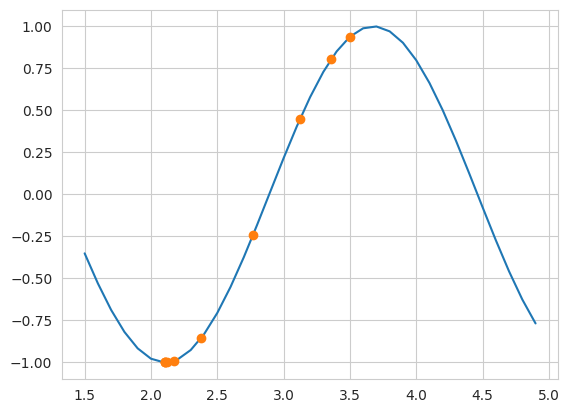

In [131]:

x = [h['vars'][0] for h in history]
y = [h['loss'] for h in history]

x_fn = np.arange(1.5, 5, 0.1)
y_fn = [fn([x]).numpy().squeeze() for x in x_fn]

plt.plot(x_fn, y_fn, '-')
plt.plot(x, y, 'o')


### Regressão de Parábola

In [ ]:
NameManager.reset()

# optimize coefficients
a = Tensor(1)
b = Tensor(1)
c = Tensor(1)

class LossFn:
    def __init__(self):
        # generate dataset
        self.x = np.arange(-5, 5, 0.2)
        self.y = -0.5 * self.x ** 2 + 1 * self.x - 5

    def __call__(self, inputs):
        a, b, c = inputs

        total_loss = Tensor(0.0)

        for x_i, y_i in zip(self.x, self.y):
            prd = add(add(prod(a, x_i ** 2), prod(b, x_i)), c)
            loss = prod(square(sub(y_i, prd)), 1/len(self.x))
            total_loss = add(total_loss, loss)

        return total_loss

loss_fn = LossFn()
params = [a, b, c]
history = gd(loss_fn, 500, 7e-3, params)



[[468.11988]]
[[11.23744573]]
[[8.23565315]]
[[6.03611735]]
[[4.4240224]]
[[3.24247741]]
[[2.37649334]]
[[1.74179181]]
[[1.27660308]]
[[0.93565454]]


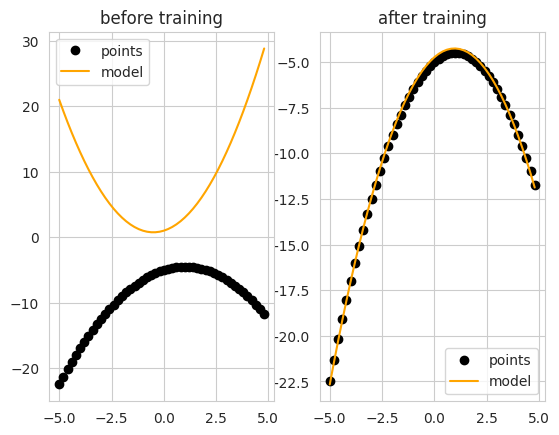

In [ ]:

plt.subplot(1, 2, 2)

a0, b0, c0 = history[0]['vars']

init_prd = a0 * loss_fn.x ** 2 + b0 * loss_fn.x + c0
final_prd = a.numpy().squeeze() * loss_fn.x ** 2 + b.numpy().squeeze() * loss_fn.x + c.numpy().squeeze()

plt.subplot(1, 2, 1)
plt.title('before training')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='black', label='points')
plt.plot(loss_fn.x, init_prd, '-', color='orange', label='model')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('after training')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='black', label='points')
plt.plot(loss_fn.x, final_prd, '-', color='orange', label='model')
plt.legend()

plt.show()



### Regressão de Funções Periódicas

In [ ]:
NameManager.reset()

class SinRegLossFn:
    def __init__(self):
        self.x = np.arange(-3.0, 3.0, 0.2)
        self.y = np.sin(self.x * 5 + 1)

    def __call__(self, inputs):
        a, m = inputs

        total_loss = Tensor(0.0)

        for x_i, y_i in zip(self.x, self.y):
            prd = sin(add(prod(x_i, m), a))
            loss = prod(square(sub(y_i, prd)), 1/len(self.x))
            total_loss = add(total_loss, loss)

        return total_loss

# optimize coefficients
a = Tensor(5.2)
m = Tensor(5)

np.random.seed(1)
loss_fn = SinRegLossFn()
params = [a, m]
history = gd(loss_fn, 20, 2e-1, params)


[[1.46293346]]
[[1.28963745]]
[[1.09799693]]
[[0.90194422]]
[[0.7153339]]
[[0.5485333]]
[[0.40753614]]
[[0.29423467]]
[[0.20722436]]
[[0.14297783]]
[[0.09706196]]
[[0.06508453]]
[[0.04324698]]
[[0.028547]]
[[0.01875356]]
[[0.01227707]]
[[0.0080168]]
[[0.00522509]]
[[0.00340081]]
[[0.00221116]]


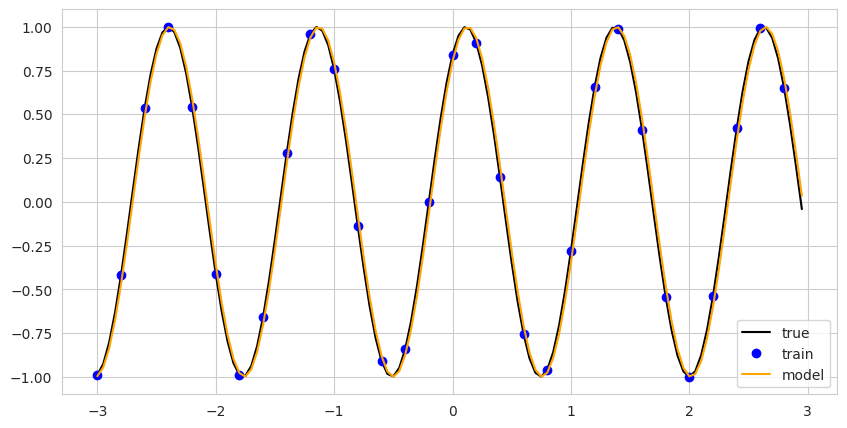

In [ ]:
# dados apenas para plotar com mais suavidade
all_x = np.arange(-3.0, 3.0, 0.05)
all_y = np.sin(all_x * 5 + 1)

a, m = history[-1]['vars']
prd_y = np.sin(all_x * m + a)

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='blue', label='train')
plt.plot(all_x, prd_y, '-', color='orange', label='model')
plt.legend()
plt.show()

## Regressão com Redes Neurais

Fazemos um treino com cada tipo de função de ativação.

In [ ]:

NameManager.reset()


def init(nrows, ncols):
    return 0.1 * np.random.normal(size=(nrows, ncols))

class Mlp:
    def __init__(self, act_fn):
        self._act_fn = act_fn

        self._w0 = Tensor(init(64, 1), name='weights')
        self._b0 = Tensor(init(64, 1), name='bias')

        self._w1 = Tensor(init(64, 64), name='weights')
        self._b1 = Tensor(init(64, 1), name='bias')

        self._w2 = Tensor(init(1, 64), name='weights')
        self._b2 = Tensor(init(1, 1), name='bias')

    def forward(self, x):
        z0 = add(matmul(self._w0, x), self._b0)
        h0 = self._act_fn(z0)

        z1 = add(matmul(self._w1, h0), self._b1)
        h1 = self._act_fn(z1)

        y = add(matmul(self._w2, h1), self._b2)

        return y

    def parameters(self):
        return [self._w0, self._b0, self._w1, self._b1]


class NeuralSinRegLossFn:
    def __init__(self, mlp):
        self.x = np.arange(-3.0, 3.0, 0.2)
        self.y = np.sin(self.x)
        self.y += np.random.normal(size=self.y.shape) * 0.2
        self.mlp = mlp

    def __call__(self, inputs):
        # vamos usar a mlp diretamente dado que seus
        # parametros sao armazenados por referencia

        total_loss = Tensor(0.0)

        for x_i, y_i in zip(self.x, self.y):
            prd = self.mlp.forward(x_i)
            loss = prod(square(sub(y_i, prd)), 1/len(self.x))
            total_loss = add(total_loss, loss)

        return total_loss

np.random.seed(1)
mlp = Mlp(relu)
loss_fn = NeuralSinRegLossFn(mlp)
params = mlp.parameters()
history = gd(loss_fn, 3000, 1e-1, params)

[[0.60539212]]
[[0.0852884]]
[[0.05724559]]
[[0.04534972]]
[[0.04023955]]
[[0.03703433]]
[[0.03409913]]
[[0.03161883]]
[[0.02931419]]
[[0.02811975]]
[[0.02716084]]
[[0.02635995]]
[[0.02567843]]
[[0.02507809]]
[[0.02453386]]
[[0.02403302]]
[[0.02356425]]
[[0.0231234]]
[[0.02274007]]
[[0.02235428]]


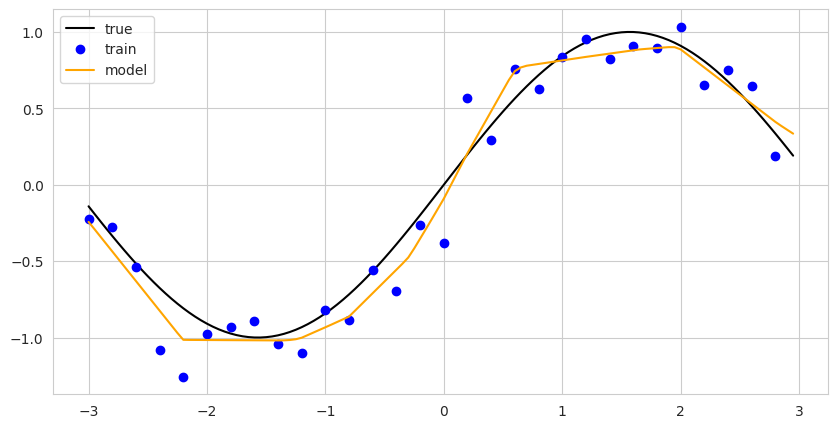

In [ ]:
# dados apenas para plotar com mais suavidade
all_x = np.arange(-3.0, 3.0, 0.05)
all_y = np.sin(all_x)

prd_y = [mlp.forward(x_i).numpy().squeeze() for x_i in all_x]

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='blue', label='train')
plt.plot(all_x, prd_y, '-', color='orange', label='model')
plt.legend()
plt.show()

Usando a `tanh` como função de ativação.

In [ ]:

np.random.seed(1)
mlp = Mlp(tanh)
loss_fn = NeuralSinRegLossFn(mlp)
params = mlp.parameters()
history = gd(loss_fn, 3000, 1e-1, params)

[[0.64213178]]
[[0.19237464]]
[[0.19303873]]
[[0.19372081]]
[[0.19431649]]
[[0.19480904]]
[[0.19521402]]
[[0.1955518]]
[[0.19583917]]
[[0.19608832]]
[[0.19630778]]
[[0.1965035]]
[[0.19667972]]
[[0.19683956]]
[[0.19698538]]
[[0.19711902]]
[[0.19724198]]
[[0.19735548]]
[[0.19746057]]
[[0.19755811]]


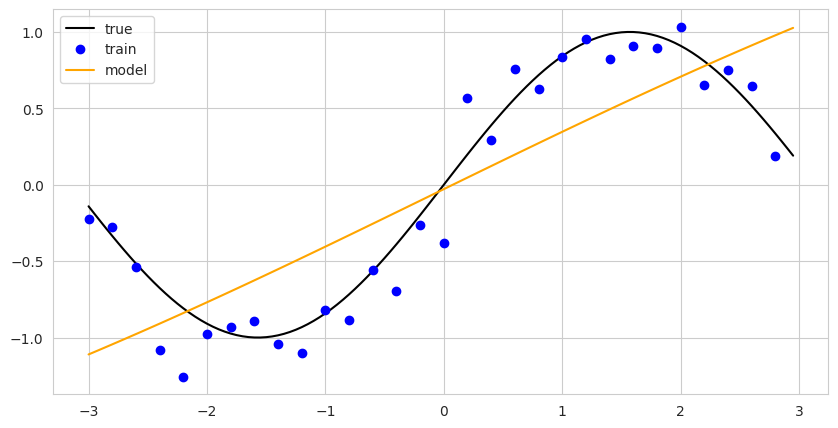

In [ ]:
# dados apenas para plotar com mais suavidade
all_x = np.arange(-3.0, 3.0, 0.05)
all_y = np.sin(all_x)

prd_y = [mlp.forward(x_i).numpy().squeeze() for x_i in all_x]

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='blue', label='train')
plt.plot(all_x, prd_y, '-', color='orange', label='model')
plt.legend()
plt.show()

Usando a sigmoide.

In [ ]:

np.random.seed(1)
mlp = Mlp(sigmoid)
loss_fn = NeuralSinRegLossFn(mlp)
params = mlp.parameters()
history = gd(loss_fn, 3000, 7e-1, params)

[[0.61286181]]
[[0.17518458]]
[[0.17834124]]
[[0.18072368]]
[[0.18250162]]
[[0.18385272]]
[[0.18490591]]
[[0.18574765]]
[[0.18643554]]
[[0.18700863]]
[[0.18749401]]
[[0.18791095]]
[[0.18827348]]


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7e6ae1f87e30>>
Traceback (most recent call last):
  File "/home/luise/RedesNeurais_202501/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


[[0.18859203]]


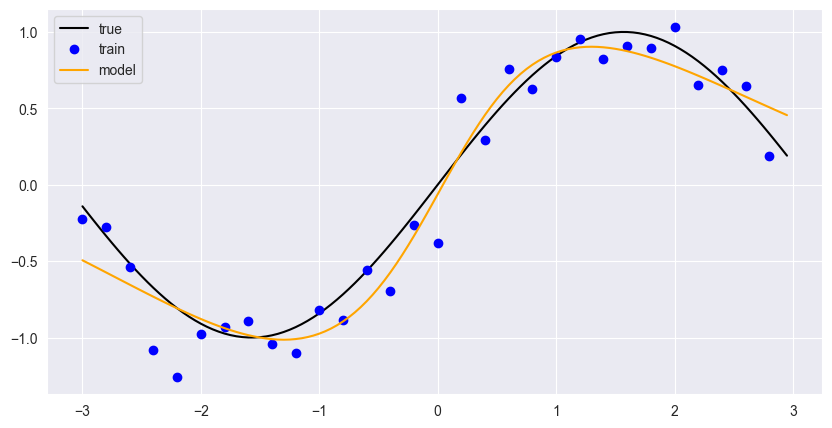

In [ ]:
# dados apenas para plotar com mais suavidade
all_x = np.arange(-3.0, 3.0, 0.05)
all_y = np.sin(all_x)

prd_y = [mlp.forward(x_i).numpy().squeeze() for x_i in all_x]

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='blue', label='train')
plt.plot(all_x, prd_y, '-', color='orange', label='model')
plt.legend()
plt.show()

In [ ]:
import pickle

with open("data.pkl", "wb") as f:
    pickle.dump(results, f)